In this notebook we visualize the attention between subjects, objects and predicates in clauses in Biblical Hebrew that contain each of these three phrases. At the same time, subject, object and predicate should consist of one word each, to simplify the task. 

BERT models return:

* outputs[0]: logits, 
* outputs[1]: hidden_states 
* outputs[2]: attentions



https://www.kdnuggets.com/how-to-visualize-model-internals-and-attention-in-hugging-face-transformers

In [1]:
import collections
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [2]:
import torch
torch.cuda.empty_cache() 

In [3]:
sp_dict = {}
text_dict = {}

for cl in F.otype.s('clause'):
    sp_dict[cl] = [F.pdp.v(w) for w in L.d(cl, 'word')]   
    heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(cl, 'word')]).strip()
    text_dict[cl] = heb_text

In [4]:
# available models:

# avichr/heBERT
# dicta-il/dictabert
# dicta-il/BEREL
# dicta-il/BEREL_2.0
# onlplab/alephbert-base


In [5]:
model_name = 'dicta-il/BEREL_2.0'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = BertForMaskedLM.from_pretrained(model_name,
                                        output_hidden_states=True, 
                                        output_attentions=True).to(device)

model.eval()

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [8]:
def get_model_outputs(model, inputs):
    outputs = model(**inputs)
    return outputs

In [10]:
def get_sp_attention(pdp_dict, one_head_attn, sp_list, layer_idx, attn_head_idx):
    for idx, pdp in enumerate(sp_list):
        for idx2, pdp2 in enumerate(sp_list):
            idx_ = idx + 1
            idx2_ = idx2 + 1
            #print(sp_list)
            #print(num_tokens)
            #print(one_head_attn)
            #print()
            pdp_attention = one_head_attn[idx_, idx2_]
            pdp_dict[layer_idx][attn_head_idx][(pdp, pdp2)].append(pdp_attention)

    return pdp_dict
            

In [13]:
pdp_dict = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(list)))
n = 0


for cl in F.otype.s('clause'):
    text = text_dict.get(cl)
    tokenized_inputs = tokenizer(text, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}

    num_tokens = len(tokenized_inputs['input_ids'][0]) - 2
    sp_list = sp_dict.get(cl)
    if len(sp_list) != num_tokens:
        continue

    n += 1
    if n > 1000:
        break
        
    with torch.no_grad():
        outputs = get_model_outputs(model, tokenized_inputs)
        attention = outputs[2]
        for layer_idx in range(12):
            attention_one_layer = attention[layer_idx]
            for attn_head_idx in range(12):
                one_head_attn = (attention_one_layer[0][attn_head_idx]).cpu().numpy()
                sp_list = sp_dict.get(cl)
                
                pdp_dict = get_sp_attention(pdp_dict, one_head_attn, sp_list, layer_idx, attn_head_idx)
            
#pdp_dict       

### First, we visualize all 12 attention head outputs of the first layer of one clause

In [205]:
tokenized_inputs = tokenizer('ויקרא אלהים לאור יום', max_length=128, truncation=True, padding=True, return_tensors="pt")
tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
with torch.no_grad():
    outputs = get_model_outputs(model, tokenized_inputs)

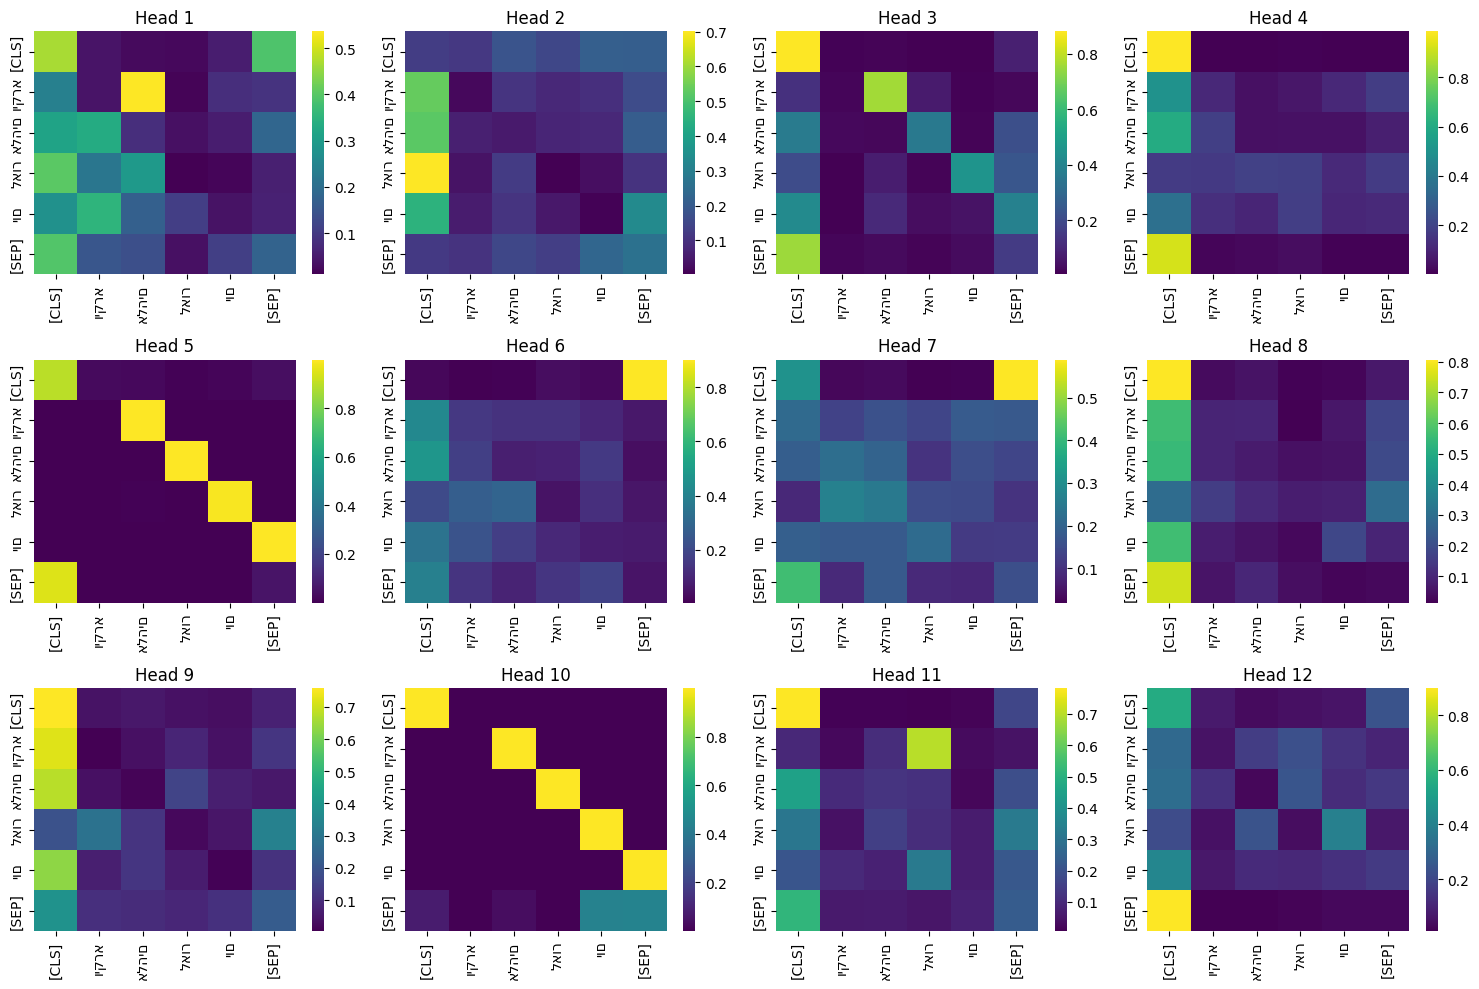

In [206]:
attention = outputs[2]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    sns.heatmap(attention[0][0][i].detach().cpu().numpy(), ax=ax, cmap="viridis",
                xticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0]),
                yticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])
               )
    ax.set_title(f"Head {i+1}")
plt.tight_layout()
plt.show()

In [201]:
# rowsums of attention are 1
attention[2][0, 1].sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [202]:
def get_detailed_attention_head_output(phr_ids, attention_head_output):
    subj_idx = phr_ids[0] + 1
    obj_idx = phr_ids[1] + 1
    pred_idx = phr_ids[2] + 1

    so_attn = attention_head_output[subj_idx, obj_idx]
    sp_attn = attention_head_output[subj_idx, pred_idx]

    os_attn = attention_head_output[obj_idx, subj_idx]
    op_attn = attention_head_output[obj_idx, pred_idx]

    ps_attn = attention_head_output[pred_idx, subj_idx]
    po_attn = attention_head_output[pred_idx, obj_idx]
    return so_attn, sp_attn, os_attn, op_attn, ps_attn, po_attn

In [210]:
n_layers = 12
n_heads = 12

attention_scores = np.zeros((n_layers, n_heads, len(subj_obj_clauses), 6))

dissimilar_words_and_tokens = 0

for cl_enum, (cl_id, text) in enumerate(subj_obj_clauses.items()):
   
    phr_ids = phrase_indices.get(cl_id, None)
    tokenized_inputs = tokenizer(text, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}

    num_tokens = len(tokenized_inputs['input_ids'][0]) - 2
    if len(text.split()) != num_tokens:
        dissimilar_words_and_tokens += 1
        continue
    
    with torch.no_grad():
        outputs = get_model_outputs(model, tokenized_inputs)
        
        attention = outputs[2]
        for layer_idx in range(12):
            attention_one_layer = attention[layer_idx]
            for attn_head_idx in range(12):
                one_head_attn = attention_one_layer[0][attn_head_idx]
                so_attn, sp_attn, os_attn, op_attn, ps_attn, po_attn = get_detailed_attention_head_output(phr_ids, one_head_attn)

                attention_scores[layer_idx, attn_head_idx, cl_enum, 0] = so_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 1] = sp_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 2] = os_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 3] = op_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 4] = ps_attn
                attention_scores[layer_idx, attn_head_idx, cl_enum, 5] = po_attn

In [211]:
dissimilar_words_and_tokens

260

In [212]:
attention_labels = ['SO','SP','OS','OP','PS','PO']

In [213]:
# Scores for each layer:

# sum over all heads and all texts
each_layer_means = np.apply_over_axes(np.sum, attention_scores, [1,2])
each_layer_means = np.squeeze(each_layer_means)

## Figure 2.

<Axes: >

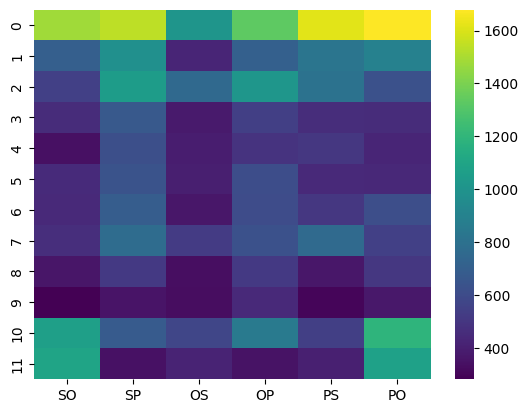

In [214]:
sns.heatmap(each_layer_means, cmap="viridis",
                xticklabels=attention_labels,
                yticklabels=list(range(12))
               )

In [215]:
# Scores for each head

In [216]:
# sum over all layers and all texts
each_head_means = np.apply_over_axes(np.sum, attention_scores, [0,2])
each_head_means = np.squeeze(each_head_means)

# Figure 3.

<Axes: >

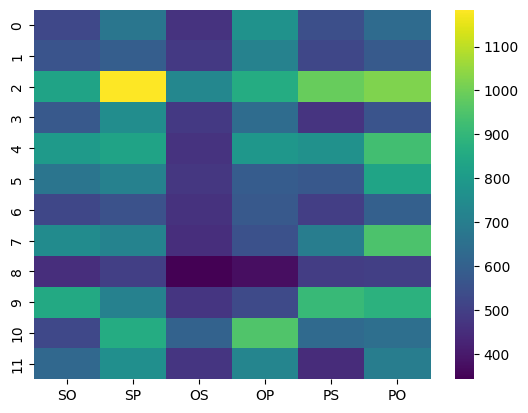

In [217]:
sns.heatmap(each_head_means, cmap="viridis",
                xticklabels=attention_labels,
                yticklabels=list(range(12))
               )